<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 3 - Ensamblados y modelos avanzados </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Técnicas de ensamblado: *bagging*, *boosting*, *random forest*.
* Redes Neuronales Convolucionales vs *Feed Forward*
* Aprendizaje no supervisado: *hidden models*
* Aprendizaje sobre secuencias
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 21 de Diciembre (11:55 hrs)
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF393-II-2018]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Calidad de un vino  
[2.](#segundo) Redes Convolucionales sobre imágenes  
[3.](#tercero) Cadenas de Markov

<a id="tercero"></a>
## 3. [Opcional] Cadenas de Markov
---
> *Dado que esta actividad es opcional, el puntaje obtenido si se realiza será equivalente a un bonus sobre el promedio final de notas de tareas.*

En esta sección emplearemos un modelo **no supervisado** especializado en secuencias, como lo son las cadenas de markov, para modelar series de tiempo, es decir una serie de registros (tı́picamente valores reales) regularmente indexados en el tiempo. Parea ello utilizaremos el dataset denominado “*international airline passengers*” [[5]](#refs). La tarea consiste en predecir el número de pasajeros (miles) en vuelos internacionales.


<img src="https://i.imgur.com/Fyf0LK6.png" title="Title text" width="80%" />

Los datos pueden ser descargados a través del siguiente __[link](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line)__. También están disponibles en Kaggle a través del siguiente __[link](https://www.kaggle.com/andreazzini/international-airline-passengers)__

Para la actividad se trabajará con la librería de *sklearn* para aprendizaje sobre secuencias HMM (*Hidden Markov Model*), también puede acudir a la documentación online a través del siguiente __[link](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#available-models)__.
```
pip install --upgrade hmmlearn
conda install -c omnia hmmlearn
```

> a) Escriba una función que cargue los datos, los divida en conjuntos de entrenamiento y de pruebas. En base a como trabajan las cadenas de markov ¿Es necesario escalar los datos?
```python
import pandas as pd
name_f = "international-airline-passengers.csv"
dataframe = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)
dataframe[:] = dataframe[:].astype('float32')
X_train, X_test = dataframe[:96].values, dataframe[96:].values
```


> b) Para resolver el problema defina un modelo de cadena de markov de primer orden con estados ocultos (*hidden markov model*) simple con un generador de datos osbervados que e distribuye normal $p(x_t|s_t)=\mathcal{N}(\mu_{s},\sigma_{s})$. Para evaluar mida la log-verosimilitud (*log-likelihood*) del modelo sobre el conjunto de entrenamiento y de pruebas. Comente
```python
from hmmlearn import hmm
import numpy as np
np.random.seed(30)
n_state = 3
markov_model = hmm.GaussianHMM(n_components=n_state, n_iter=100)
markov_model.fit(X_train)
markov_model.score(X_train)
markov_model.score(X_val)
```

> c) Analice cualitativamente lo que aprendió el modelo a través de las distribuciones de probabilidad de las observaciones para un estado oculto dado, esto es, $p(x_t|s_t)$, y las distribuciones de probabilidad de transición $p(s_{t+1}|s_t)$. Comente.
```python
import seaborn as sns
from scipy.stats import norm
import itertools
for i in range(n_state):
    r = norm(markov_model.means_[i], np.sqrt( markov_model.covars_[i,0])).rvs(10000)
    sns.distplot(r,kde=True, hist=False,label="Estado "+str(i))
plt.legend()
plt.title("Distribuciones de cada estado")
plt.show()
def plot_state_matrix(cm, states,title='Transition Probabilities',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(states))
    plt.xticks(tick_marks, states)
    plt.yticks(tick_marks, states)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('Origin state')
    plt.xlabel('Destination state')
    plt.tight_layout()
plot_state_matrix(markov_model.transmat_,np.arange(n_state))
```

> d) Gracias a que el modelo no predice un valor único, sino que una distribucipon de probabilidad (incerteza en cada valor continuo), realice un gráfico de ésto, es decir, visualice el intervalo de confianza en que el modelo predice en cada instante de tiempo, dado el estado oculto, y contrarréstelo con la secuencia original. Hágalo para el conjunto de entrenamiento y de pruebas
```python
X_state = markov_model.predict(X) #predice el estado, no el valor
plt.fill_between(np.arange(X.shape[0]),markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0], markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0])
plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media")
plt.plot(X,'ro-',label="Data") #-- here put train or val
plt.legend()
plt.show()
```


> e) Dado que se ve que el problema no puede ser modelado de manera adecuada con 3 estados distintos (valores que puede tomar el estado oculto en cada instante de tiempo, $s_t$). Experimente con variar la cantidad de éstos  ¿Qué sucede si aumenta hasta tener la misma cantidad de estados que la cantidad de datos? Visualice lo que estime conveniente, además de medir el *log-likelihood* en cada conjunto.
```python
n_states = np.arange(1,50)
markov_model = hmm.GaussianHMM(n_components=n_state, n_iter=100)
markov_model.fit(X_train)
```


> f) Debido a que el modelo no predice el valor continuo directamente, sino que predice el estado oculto de cada instante de tiempo, es necesario hacer un muestreo para obtener el valor continuo (o si desea, quedarse con la media). Realice este muestreo y evalúe la métrica de MSE (*Mean Square Error*) sobre el conjunto de pruebas.
```python
X_state = markov_model.predict(X_test) #predice el estado, no el valor
X_output = norm( markov_model.means_[X_state], np.sqrt(markov_model.covars_[X_state][:,0]) ).rvs() #rvs is sample
from  sklearn.metrics import mean_squared_error as mse
mse(X_test, X_output)
```

> ¿Cambian mucho los resultados si se emplea una mezcla de gausianas como modelo para $p(x_t|s_t)$ en ves de que cada estado pertenezca a un único modelo Gausiano (distribución normal)?
```python
from hmmlearn.hmm import GMMHMM
markov_model2 = GMMHMM(n_components=n_state, n_mix=3, n_iter=100)
```

> a) Escriba una función que cargue los datos, los divida en conjuntos de entrenamiento y de pruebas. En base a como trabajan las cadenas de markov ¿Es necesario escalar los datos?
```python
import pandas as pd
name_f = "international-airline-passengers.csv"
dataframe = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)
dataframe[:] = dataframe[:].astype('float32')
X_train, X_test = dataframe[:96].values, dataframe[96:].values
```

Las cadenas de Markov trabajan con probabilidades. En si se basan en que la probabilidad de que ocurra un suceso depende del suceso anterior. Dado esto, es irrelevante escalar los datos ya que tendrán el mismo significado escalados o no, ya que representarán lo mismo. Además, las cadenas de markov representan probabilidades de estar en un determinado estado.

In [55]:
import pandas as pd
name_f = "international-airline-passengers.csv"
dataframe = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)
dataframe[:] = dataframe[:].astype('float32')
X_train, X_test = dataframe[:96].values, dataframe[96:].values
X_val = X_train[77:]
X_train = X_train[:77]



> b) Para resolver el problema defina un modelo de cadena de markov de primer orden con estados ocultos (*hidden markov model*) simple con un generador de datos observados que se distribuye normal $p(x_t|s_t)=\mathcal{N}(\mu_{s},\sigma_{s})$. Para evaluar mida la log-verosimilitud (*log-likelihood*) del modelo sobre el conjunto de entrenamiento y de pruebas. Comente.
```python
from hmmlearn import hmm
import numpy as np
np.random.seed(30)
n_state = 3
markov_model = hmm.GaussianHMM(n_components=n_state, n_iter=100)
markov_model.fit(X_train)
markov_model.score(X_train)
markov_model.score(X_val)
```

Se entrena un modelo de cadenas de markov con 3 estados y 100 iteraciones. Luego de eso, se imprime el valor de la log-verosimilitud del modelo para el conjunto de entrenamiento y validación.

In [56]:
from hmmlearn import hmm
import numpy as np
np.random.seed(30)
n_state = 3
markov_model = hmm.GaussianHMM(n_components=n_state, n_iter=100)
markov_model.fit(X_train)
# Se imprime la log-verosimilitud de los conjuntos de entrenamiento y prueba.
print(markov_model.score(X_train))
print(markov_model.score(X_val))

-351.062072483562
-311.6860176719218


La log-verosimilitud corresponde al logaritmo de la probabilidad del modelo entrenado. En este caso la probabilidad del modelo de entrenamiento es menor que la probabilidad del modelo de validación.

> c) Analice cualitativamente lo que aprendió el modelo a través de las distribuciones de probabilidad de las observaciones para un estado oculto dado, esto es, $p(x_t|s_t)$, y las distribuciones de probabilidad de transición $p(s_{t+1}|s_t)$. Comente.
```python
import seaborn as sns
from scipy.stats import norm
import itertools
for i in range(n_state):
    r = norm(markov_model.means_[i], np.sqrt( markov_model.covars_[i,0])).rvs(10000)
    sns.distplot(r,kde=True, hist=False,label="Estado "+str(i))
plt.legend()
plt.title("Distribuciones de cada estado")
plt.show()
def plot_state_matrix(cm, states,title='Transition Probabilities',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(states))
    plt.xticks(tick_marks, states)
    plt.yticks(tick_marks, states)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('Origin state')
    plt.xlabel('Destination state')
    plt.tight_layout()
plot_state_matrix(markov_model.transmat_,np.arange(n_state))
```

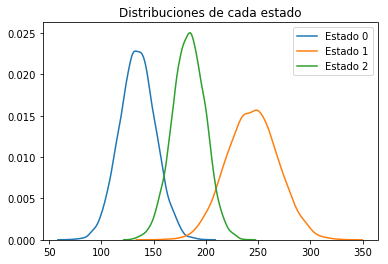

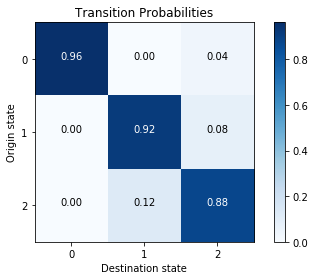

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import itertools
for i in range(n_state):
    r = norm(markov_model.means_[i], np.sqrt( markov_model.covars_[i,0])).rvs(10000)
    sns.distplot(r,kde=True, hist=False,label="Estado "+str(i))
plt.legend()
plt.title("Distribuciones de cada estado")
plt.show()
def plot_state_matrix(cm, states,title='Transition Probabilities',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(states))
    plt.xticks(tick_marks, states)
    plt.yticks(tick_marks, states)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('Origin state')
    plt.xlabel('Destination state')
    plt.tight_layout()
plot_state_matrix(markov_model.transmat_,np.arange(n_state))

Viendo la destribuciones del gráfico, podemos notas que el estado 0 y el estado 1 tienen una distribución con menor varianza. El estado 0 tiene la mayor probabilidad en el valor 140, el estado 2 alrededor del valor 280 y finalmente el estado 1 tiene como mayor probabilidad al rededor del valor 280. El estado 0 se extiene aproximadamente entre los valores 70 y 290, el estado 1 entre los valores 160 y 330, el estado 2 entre los valores 140 y 240. Con esto se tiene que el estado más acotado es el 2 y el estado que más abarca el rango de pasajeros es el estado 1.

Analizando las posibilidades de transición, lo más probable es que una estado pase de nuevo al mismo estado. En el caso del estado 0, este es muy probable que se mantenga en 0, muy poco probable que cambie al estado 2 y no es posible que pase al estado 1. El estado 1 puede pasar con mayor probabilidad al mismo estado, una leve probabilidad de pasar al estado 2 y no es posible que pase al estado 0. Finalmente, el estado 2 es bastante probable que pase al mismo estado pero es el que tiene menos probabilidades de permanecer en el mismo estado de los 3, también es posible que pase al estado 1 con leve probabilidad y no puede ir al estado 0. Estos datos hacen pensar que las variaciones durantes los años de la cantidad de pasajeros no es tan drástica, no es tan probable que los pasajeros aumenten ni disminuyan, es más probable que estos se mantengan alrededor de la misma cantidad.

> d) Gracias a que el modelo no predice un valor único, sino que una distribucipon de probabilidad (incerteza en cada valor continuo), realice un gráfico de ésto, es decir, visualice el intervalo de confianza en que el modelo predice en cada instante de tiempo, dado el estado oculto, y contrarréstelo con la secuencia original. Hágalo para el conjunto de entrenamiento y de pruebas
```python
X_state = markov_model.predict(X) #predice el estado, no el valor
plt.fill_between(np.arange(X.shape[0]),markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0], markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0])
plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media")
plt.plot(X,'ro-',label="Data") #-- here put train or val
plt.legend()
plt.show()
```

Para el conjunto de entrenamiento:

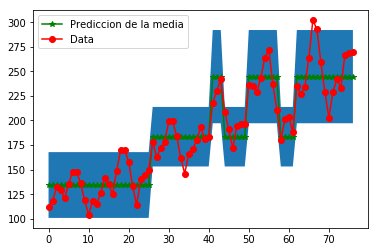

In [58]:
X_state = markov_model.predict(X_train) #predice el estado, no el valor
plt.fill_between(np.arange(X_train.shape[0]),markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0], markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0])
plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media")
plt.plot(X_train,'ro-',label="Data") #-- here put train or val
plt.legend()
plt.show()

Para el conjunto de entrenamiento, se puede notar que la mayoría de los datos está dentro del intervalo de confianza entregado por el modelo. Solo unos pocos datos se salen de las zonas marcadas.

Para el conjunto de pruebas:

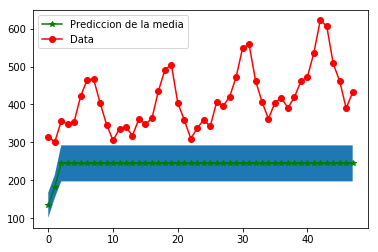

In [59]:
X_state = markov_model.predict(X_test) #predice el estado, no el valor
plt.fill_between(np.arange(X_test.shape[0]),markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0], markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0])
plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media")
plt.plot(X_test,'ro-',label="Data") #-- here put train or val
plt.legend()
plt.show()

Para este conjunto, ninguno de los puntos está dentro de la zona. Esto quiere decir que el modelo no está haciendo una predicción correcta.

> e) Dado que se ve que el problema no puede ser modelado de manera adecuada con 3 estados distintos (valores que puede tomar el estado oculto en cada instante de tiempo, $s_t$). Experimente con variar la cantidad de éstos  ¿Qué sucede si aumenta hasta tener la misma cantidad de estados que la cantidad de datos? Visualice lo que estime conveniente, además de medir el *log-likelihood* en cada conjunto.
```python
n_states = np.arange(1,50)
markov_model = hmm.GaussianHMM(n_components=n_state, n_iter=100)
markov_model.fit(X_train)
```



Se irá variando la cantidad de estados de 10 en 10. Se visualizarán los gráficos de intervalos de confianza para cada una.

In [60]:
markov_model = hmm.GaussianHMM(n_components=10, n_iter=100)
markov_model.fit(X_train)
print(markov_model.score(X_train))
print(markov_model.score(X_val))


-305.23212376135467
-1658.7850592067377


Al aumentar a 10 los estados, el log verisimilitud se redujo considerablemnete para el conjunto de validación.

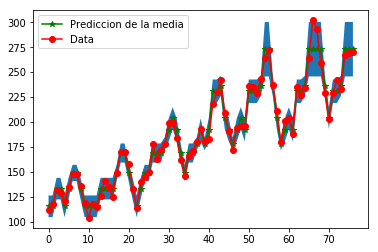

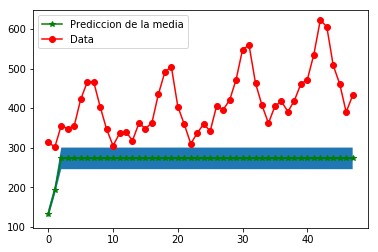

In [61]:
X_state = markov_model.predict(X_train) #predice el estado, no el valor
plt.fill_between(np.arange(X_train.shape[0]),markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0], markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0])
plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media")
plt.plot(X_train,'ro-',label="Data") #-- here put train or val
plt.legend()
plt.show()
X_state = markov_model.predict(X_test) #predice el estado, no el valor
plt.fill_between(np.arange(X_test.shape[0]),markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0], markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0])
plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media")
plt.plot(X_test,'ro-',label="Data") #-- here put train or val
plt.legend()
plt.show()

Nuevamente ocurre lo mismo, el modelo logra predecir muy bien el conjunto de pruebas pero se aleja bastatante del conjunto de pruebas. Se aumenta en 10 los estados posibles.

In [62]:
markov_model = hmm.GaussianHMM(n_components=20, n_iter=100)
markov_model.fit(X_train)
print(markov_model.score(X_train))
print(markov_model.score(X_val))


-241.36934438648157
-4119.3979009229715


El log vrosimilitud se ha aumentado en el conjunto de entrenamiento mientras que en el conjunto de validación se ha reducido.

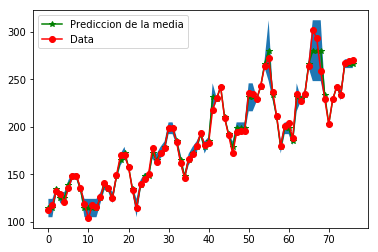

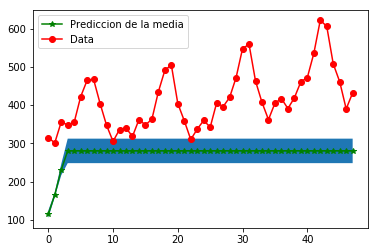

In [63]:
X_state = markov_model.predict(X_train) #predice el estado, no el valor
plt.fill_between(np.arange(X_train.shape[0]),markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0], markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0])
plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media")
plt.plot(X_train,'ro-',label="Data") #-- here put train or val
plt.legend()
plt.show()
X_state = markov_model.predict(X_test) #predice el estado, no el valor
plt.fill_between(np.arange(X_test.shape[0]),markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0], markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0])
plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media")
plt.plot(X_test,'ro-',label="Data") #-- here put train or val
plt.legend()
plt.show()

Con 20 estados, nuevamente el modelo predice bien el conjunto de entrenamiento pero no así el de prueba. Cabe destacar que esta vez, dos puntos del conjunto de prueba están dentro del intervalo de confianza. Se vuelve a aumentar en 10 la cantidad de estados posibles.

In [64]:
markov_model = hmm.GaussianHMM(n_components=30, n_iter=100)
markov_model.fit(X_train)
print(markov_model.score(X_train))
print(markov_model.score(X_val))

-184.18486056508712
-3387.721029000256


Nuevamente el log verosimilitud del conjunto de entrenamiento volvió a aumentar y además, el del conjunto de validación tuvo un ligero aumento.

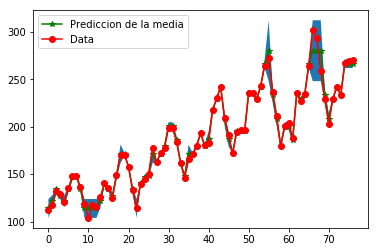

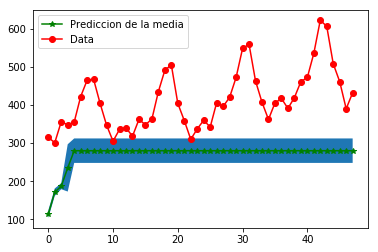

In [65]:
X_state = markov_model.predict(X_train) #predice el estado, no el valor
plt.fill_between(np.arange(X_train.shape[0]),markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0], markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0])
plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media")
plt.plot(X_train,'ro-',label="Data") #-- here put train or val
plt.legend()
plt.show()
X_state = markov_model.predict(X_test) #predice el estado, no el valor
plt.fill_between(np.arange(X_test.shape[0]),markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0], markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0])
plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media")
plt.plot(X_test,'ro-',label="Data") #-- here put train or val
plt.legend()
plt.show()

Se repiten los mismos resultados que la iteración anterios. Se procede a aumentar en 10 los estados posibles.

-126.6596963285432
-20554.83474256178


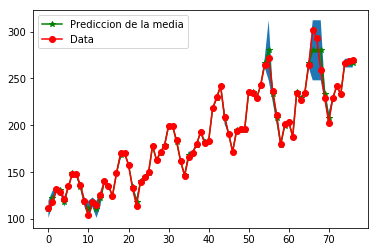

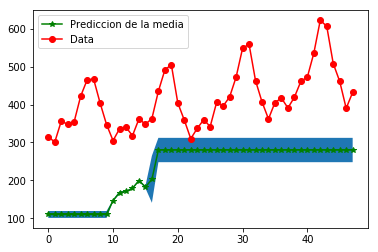

In [66]:
markov_model = hmm.GaussianHMM(n_components=40, n_iter=100)
markov_model.fit(X_train)
print(markov_model.score(X_train))
print(markov_model.score(X_val))
X_state = markov_model.predict(X_train) #predice el estado, no el valor
plt.fill_between(np.arange(X_train.shape[0]),markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0], markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0])
plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media")
plt.plot(X_train,'ro-',label="Data") #-- here put train or val
plt.legend()
plt.show()
X_state = markov_model.predict(X_test) #predice el estado, no el valor
plt.fill_between(np.arange(X_test.shape[0]),markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0], markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0])
plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media")
plt.plot(X_test,'ro-',label="Data") #-- here put train or val
plt.legend()
plt.show()

el log verosimilitud del conjunto de entrenamiento sigue aumentando de valor, mientras que el de validación está reduciendoce. Los gráficos resultantes siguen el mismo patrón que las iteraciones anteriores. Se aumenta en 10 nuevamente los estados.

-90.42034055530226
-2201.524785285593


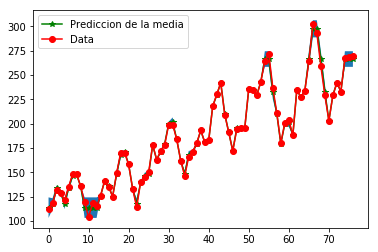

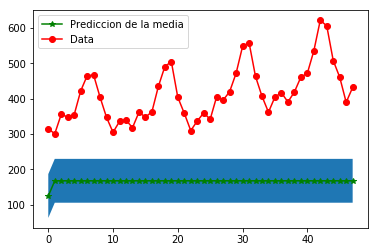

In [67]:
markov_model = hmm.GaussianHMM(n_components=50, n_iter=100)
markov_model.fit(X_train)
print(markov_model.score(X_train))
print(markov_model.score(X_val))
X_state = markov_model.predict(X_train) #predice el estado, no el valor
plt.fill_between(np.arange(X_train.shape[0]),markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0], markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0])
plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media")
plt.plot(X_train,'ro-',label="Data") #-- here put train or val
plt.legend()
plt.show()
X_state = markov_model.predict(X_test) #predice el estado, no el valor
plt.fill_between(np.arange(X_test.shape[0]),markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0], markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0])
plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media")
plt.plot(X_test,'ro-',label="Data") #-- here put train or val
plt.legend()
plt.show()

Ahora el log verosimilitud del conjunto de validación aumento considerablemente, mientras que el de entrenmiento también aumento pero una leve cantidad.

-25.768111640043923
-9904.262749060199


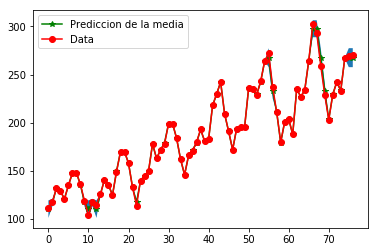

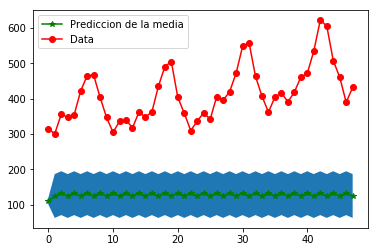

In [68]:
markov_model = hmm.GaussianHMM(n_components=77, n_iter=100)
markov_model.fit(X_train)
print(markov_model.score(X_train))
print(markov_model.score(X_val))
X_state = markov_model.predict(X_train) #predice el estado, no el valor
plt.fill_between(np.arange(X_train.shape[0]),markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0], markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0])
plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media")
plt.plot(X_train,'ro-',label="Data") #-- here put train or val
plt.legend()
plt.show()
X_state = markov_model.predict(X_test) #predice el estado, no el valor
plt.fill_between(np.arange(X_test.shape[0]),markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0], markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0])
plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media")
plt.plot(X_test,'ro-',label="Data") #-- here put train or val
plt.legend()
plt.show()

Finalmente, si la cantidad de estados es igual a la cantidad de datos, el gráfico para el conjunto de entrenamiento está hecho "a la medida", es decir, el intervalo de confianza calza perfecto con los puntos. Para el conjunto de entrenamiento no sucede lo mismo, ningún punto está dentro del intervalo de confianza y el modelo no es capaz de predecir los valores del conjunto. Se concluye que el modelo no es capaz de predecir el conjunto de pruebas, solo es capaz de predecir el conjunto de entrenamiento.


> f) Debido a que el modelo no predice el valor continuo directamente, sino que predice el estado oculto de cada instante de tiempo, es necesario hacer un muestreo para obtener el valor continuo (o si desea, quedarse con la media). Realice este muestreo y evalúe la métrica de MSE (*Mean Square Error*) sobre el conjunto de pruebas.
```python
X_state = markov_model.predict(X_test) #predice el estado, no el valor
X_output = norm( markov_model.means_[X_state], np.sqrt(markov_model.covars_[X_state][:,0]) ).rvs() #rvs is sample
from  sklearn.metrics import mean_squared_error as mse
mse(X_test, X_output)
```



In [70]:
X_state = markov_model.predict(X_test) #predice el estado, no el valor
X_output = norm( markov_model.means_[X_state], np.sqrt(markov_model.covars_[X_state][:,0]) ).rvs() #rvs is sample
from  sklearn.metrics import mean_squared_error as mse
mse(X_test, X_output)

92677.43454551866

El error mse es muy grande en este caso.

> ¿Cambian mucho los resultados si se emplea una mezcla de gausianas como modelo para $p(x_t|s_t)$ en ves de que cada estado pertenezca a un único modelo Gausiano (distribución normal)?
```python
from hmmlearn.hmm import GMMHMM
markov_model2 = GMMHMM(n_components=n_state, n_mix=3, n_iter=100)
```

In [54]:
from hmmlearn.hmm import GMMHMM
markov_model2 = GMMHMM(n_components=4, n_mix=3, n_iter=100)
markov_model2.fit(X_train)
print(markov_model2.score(X_train))
print(markov_model2.score(X_val))
X_state = markov_model2.predict(X_test) #predice el estado, no el valor
X_output = norm( markov_model2.means_[X_state], np.sqrt(markov_model2.covars_[X_state][:,0]) ).rvs() #rvs is sample
from  sklearn.metrics import mean_squared_error as mse
mse(X_test, X_output)

-431.6035305605609
-183.0762965734568


ValueError: shape mismatch: objects cannot be broadcast to a single shape

<a id="refs"></a>
## Referencias
[1] http://archive.ics.uci.edu/ml/datasets/Wine+Quality  
[2] http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  
[3] http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html, http://colah.github.io/posts/2014-07-Understanding-Convolutions/    
[4] https://www.vision.ee.ethz.ch/datasets_extra/food-101/  
[5] Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976), *Time Series Analysis, Forecasting and Control*. Third Edition. Holden-Day. Series G.  